# MomentOpt Parallel


## Adding workers

If you start julia with several processors, you can run the algorithms in parallel.

In [1]:
# add three workers
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

## Preliminaries

In [2]:
@everywhere using MomentOpt
using DataStructures
using DataFrames
using Plots

srand(1234);

# Define true values of parameters
#---------------------------------
trueValues = OrderedDict("mu1" => [-1.0], "mu2" => [1.0])


DataStructures.OrderedDict{String,Array{Float64,1}} with 2 entries:
  "mu1" => [-1.0]
  "mu2" => [1.0]

## Set up a MomentOpt problem

In [3]:
#------------------------------------------------
# Options
#-------------------------------------------------
# Boolean: do you want to save the plots to disk?
savePlots = false

#------------------------
# initialize the problem:
#------------------------

# Specify the initial values for the parameters, and their support:
pb = OrderedDict("p1" => [0.2,-3,3] , "p2" => [-0.2,-2,2])

# Specify moments to be matched + subjective weights:
moms = DataFrame(name=["mu1","mu2"],value=[trueValues["mu1"][], trueValues["mu2"][]], weight=ones(2))

# GMM objective function to be minized.
# It returns a weigthed distance between empirical and simulated moments
@everywhere function objfunc_normal(ev::Eval; verbose = false)

    start(ev)


    # when running in parallel, display worker's id:
    #-----------------------------------------------
    if verbose == true
        if nprocs() > 1
          println(myid())
        end
    end

    # extract parameters from ev:
    #----------------------------
    mu  = collect(values(ev.params))

    # compute simulated moments
    #--------------------------
    # Monte-Carlo:
    #-------------
    ns = 100000 #number of i.i.d draws from N([mu], sigma)
    #initialize a multivariate normal N([mu], sigma)
    #sigma is set to be the identity matrix
    sigma = [1.0; 1.0]
    # draw ns observations from N([mu], sigma):
    randMultiNormal = MomentOpt.MvNormal(mu,MomentOpt.PDiagMat(sigma))
    # calculate the mean of the simulated data
    simM            = mean(rand(randMultiNormal,ns),2)
    # store simulated moments in a dictionary
    simMoments = Dict(:mu1 => simM[1], :mu2 => simM[2])

    # Calculate the weighted distance between empirical moments
    # and simulated ones:
    #-----------------------------------------------------------
    v = Dict{Symbol,Float64}()
    for (k, mom) in dataMomentd(ev)
        # If weight for moment k exists:
        #-------------------------------
        if haskey(MomentOpt.dataMomentWd(ev), k)
            # divide by weight associated to moment k:
            #----------------------------------------
            v[k] = ((simMoments[k] .- mom) ./ MomentOpt.dataMomentW(ev,k)) .^2
        else
            v[k] = ((simMoments[k] .- mom) ) .^2
        end
    end

    # Set value of the objective function:
    #------------------------------------
    setValue(ev, mean(collect(values(v))))

    # also return the moments
    #-----------------------
    setMoment(ev, simMoments)

    # flag for success:
    #-------------------
    ev.status = 1

    # finish and return
    finish(ev)

    return ev
end



# Initialize an empty MProb() object:
#------------------------------------
mprob = MProb()

# Add structural parameters to MProb():
# specify starting values and support
#--------------------------------------
addSampledParam!(mprob,pb)

# Add moments to be matched to MProb():
#--------------------------------------
addMoment!(mprob,moms)

# Attach an objective function to MProb():
#----------------------------------------
addEvalFunc!(mprob, objfunc_normal)

objfunc_normal (generic function with 1 method)

In [4]:
# estimation options:
#--------------------
# number of iterations for each chain
niter = 1000
# number of chains
nchains = 3

opts = Dict("N"=>nchains,
        "maxiter"=>niter,
        "maxtemp"=> 5,
        "coverage"=>0.025,
        "sigma_update_steps"=>10,
        "sigma_adjust_by"=>0.01,
        "smpl_iters"=>1000,
        "parallel"=>true,
        "maxdists"=>[0.05 for i in 1:nchains],
        "mixprob"=>0.3,
        "acc_tuner"=>12.0,
        "animate"=>false)


#---------------------------------------
# Let's set-up and run the optimization
#---------------------------------------
# set-up BGP algorithm:
MA = MAlgoBGP(mprob,opts)

# run the estimation:
@time MomentOpt.runMOpt!(MA)

# show a summary of the optimization:
@show MomentOpt.summary(MA)

17:47:20:INFO:Main:Starting estimation loop.
17:53:02:WARN:Main:could not find 'filename' and did not save
17:53:02:INFO:Main:Done with estimation after 5.7 minutes


356.767610 seconds (186.43 M allocations: 10.131 GiB, 1.78% gc time)
MomentOpt.summary(MA) = 3×5 DataFrames.DataFrame
│ Row │ id │ acc_rate │ perc_exchanged │ exchanged_most_with │ best_val    │
├─────┼────┼──────────┼────────────────┼─────────────────────┼─────────────┤
│ 1   │ 1  │ 0.595469 │ 69.2           │ 2                   │ 4.24766e-5  │
│ 2   │ 2  │ 0.470085 │ 65.0           │ 1                   │ 4.24766e-5  │
│ 3   │ 3  │ 0.373656 │ 62.9           │ 1                   │ 0.000305779 │


3×5 DataFrames.DataFrame
│ Row │ id │ acc_rate │ perc_exchanged │ exchanged_most_with │ best_val    │
├─────┼────┼──────────┼────────────────┼─────────────────────┼─────────────┤
│ 1   │ 1  │ 0.595469 │ 69.2           │ 2                   │ 4.24766e-5  │
│ 2   │ 2  │ 0.470085 │ 65.0           │ 1                   │ 4.24766e-5  │
│ 3   │ 3  │ 0.373656 │ 62.9           │ 1                   │ 0.000305779 │

## Inference
When using the BGP algorithm, inference can be done using the first chain. Other chains are used to explore the state space and help to exit local minima.

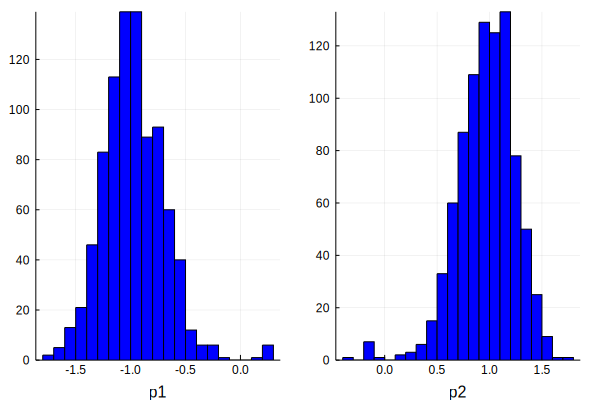

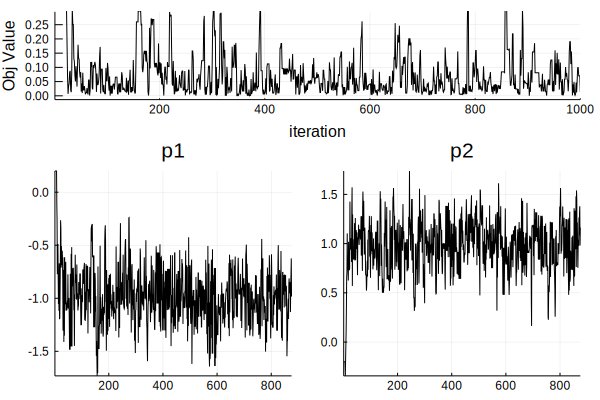

In [5]:
# Plot histograms for the first chain, the one with which inference should be done.
# Other chains are used to explore the space and avoid local minima
#-------------------------------------------------------------------------------
p1 = histogram(MA.chains[1])
display(p1)

if savePlots
    savefig(p1, joinpath(pwd(),"histogram.svg"))
end

# Plot the realization of the first chain
#----------------------------------------
p2 = plot(MA.chains[1])
if savePlots
    savefig(p2, joinpath(pwd(),"lines.svg"))
end
display(p2)

In [6]:
# Realization of the first chain:
#-------------------------------
dat_chain1 = MomentOpt.history(MA.chains[1])

# discard the first 10th of the observations ("burn-in" phase):
#--------------------------------------------------------------
dat_chain1[round(Int, niter/10):niter, :]

# keep only accepted draws:
#--------------------------
dat_chain1 = dat_chain1[dat_chain1[:accepted ].== true, : ]

# create a list with the parameters to be estimated
parameters = [Symbol(String("mu$(i)")) for i=1:2]
# list with the corresponding priors:
#------------------------------------
estimatedParameters = [Symbol(String("p$(i)")) for i=1:2]


# Quasi Posterior mean and quasi posterior median for each parameter:
#-------------------------------------------------------------------
for (estimatedParameter, param) in zip(estimatedParameters, parameters)

  println("Quasi posterior mean for $(String(estimatedParameter)) = $(mean(dat_chain1[estimatedParameter]))")
  println("Quasi posterior median for $(String(estimatedParameter)) = $(median(dat_chain1[estimatedParameter]))")
  println("True value = $(trueValues[String(param)][])")
  println("abs(True value - Quasi posterior median)  = $(abs(median(dat_chain1[estimatedParameter]) - trueValues[String(param)][])) \n")

end

Quasi posterior mean for p1 = -0.972805991156608
Quasi posterior median for p1 = -0.9867425738737515
True value = -1.0
abs(True value - Quasi posterior median)  = 0.013257426126248473 

Quasi posterior mean for p2 = 0.9694949497308334
Quasi posterior median for p2 = 0.9908164310582379
True value = 1.0
abs(True value - Quasi posterior median)  = 0.009183568941762088 



## Slices

17:53:24:INFO:Main:slicing along p1
17:53:29:INFO:Main:slicing along p2
17:53:32:INFO:Main:done after 0.0 minutes


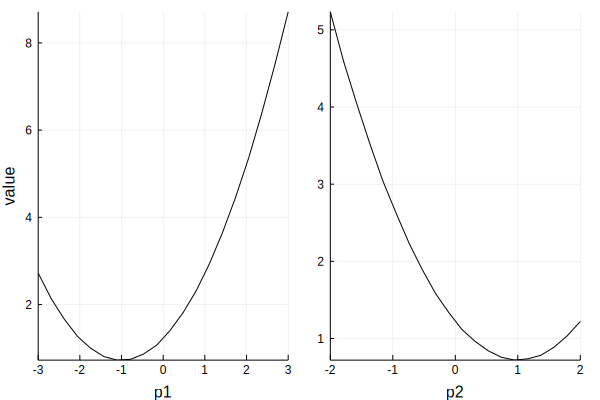

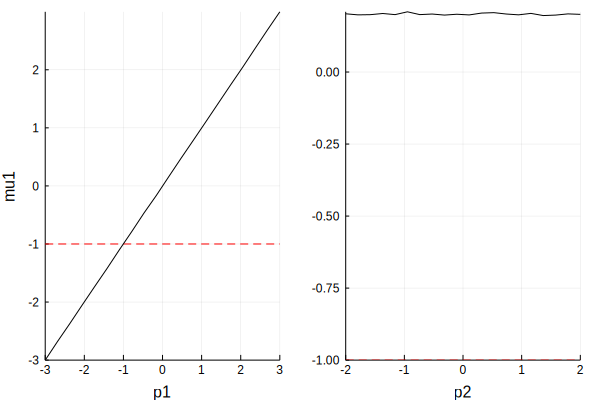

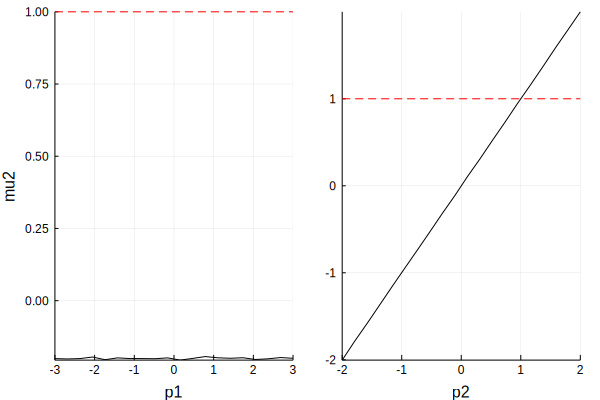

ERROR (unhandled task failure): InterruptException:
Stacktrace:
 [1] process_events at ./libuv.jl:82 [inlined]
 [2] wait() at ./event.jl:216
 [3] wait(::Condition) at ./event.jl:27
 [4] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:42
 [5] wait(::Timer) at ./event.jl:357
 [6] (::Base.##300#301{IJulia.#send_stderr,Timer})() at ./event.jl:430


In [7]:
# plot slices of objective function
# grid with 20 points
#-----------------------------------
s = doSlices(mprob,20)

# plot slices of the objective function:
#---------------------------------------
p = MomentOpt.plot(s,:value)
display(p)

if savePlots
    Plots.savefig(p, joinpath(pwd(),"slices_v.svg"))
end



# Produce more precise plots with respect to each parameter:
#-----------------------------------------------------------
for symbol in parameters

  p = MomentOpt.plot(s,symbol)
  display(p)
    
  if savePlots
      Plots.savefig(p, joinpath(pwd(),"slices_v_$(String(symbol)).svg"))
  end
    

end